# Snekmer Demo

In this notebook, we will demonstrate how to apply Snekmer toward the analysis of protein sequences.

## Getting Started

### Workflow

Snekmer proceeds through a defined workflow executed as individual steps on Snakemake. Two operation modes are available: `model` (supervised machine learning) and `cluster` (unsupervised clustering). The user should select the mode that best suits their individual use case.

<img src="https://raw.githubusercontent.com/PNNL-CompBio/Snekmer/main/resources/snekmer_workflow.svg" width="70%" height="70%" >



### Notes on Using Snekmer

Snekmer assumes that the user will primarily process input files using the command line. For more detailed instructions, refer to the [documentation](https://snekmer.readthedocs.io/en/latest/getting_started/cli.html).

The basic process for running Snekmer is as follows:

1. Verify that your file directory structure is correct and that the top-level directory contains a **config.yaml** file.
    - A template configuration file is included in the Snekmer code repository [here](https://github.com/PNNL-CompBio/Snekmer/blob/main/resources/config.yaml).
2. Modify **config.yaml** as needed.
3. Use the command line to navigate to the directory containing both the **config.yaml** file and **_input_** directory.
4. Run `snekmer cluster`, `snekmer model`, or `snekmer search`.

Depending on the selected operation mode, output files will vary.

The process detailed above is handled by the included [tutorial](https://snekmer.readthedocs.io/en/latest/tutorial/index.html). We will use this demo to break down the process followed by the tutorial and understand the output files created in the process.

## Running Snekmer

First, install Snekmer using the instructions in the [user installation guide](https://snekmer.readthedocs.io/en/latest/getting_started/install.html).

To ensure that the tutorial runs correctly, activate the conda environment containing your Snekmer installation and run the notebook from the environment.

Next, run the [Snekmer tutorial](https://snekmer.readthedocs.io/en/latest/tutorial/index.html). This runs all three Snekmer modes on the demo example files and produces all output files. The tutorial uses the included default configuration parameters to guide the analysis, but the user can modify these parameters if a different configuration set is desired. The tutorial command line instructions are copied below:

```bash
    conda activate snekmer
    cd resources/tutorial/demo_example
    ./run_demo.sh
```
    

Finally, we will initialize some parameters and parse filenames for this demo notebook.

In [1]:
# imports
import glob
import os
import yaml
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load config file
with open(os.path.join("..", "..", "resources", "config.yaml"), "r") as configfile:
    config = yaml.safe_load(configfile)

print(config)

{'k': 14, 'alphabet': 0, 'input_file_exts': ['fasta', 'fna', 'faa', 'fa'], 'input_file_regex': '.*', 'nested_output': False, 'score': {'scaler': True, 'scaler_kwargs': {'n': 0.25}, 'labels': 'None', 'lname': 'None'}, 'cluster': {'method': 'agglomerative-jaccard', 'params': {'n_clusters': 'None', 'linkage': 'average', 'distance_threshold': 0.92, 'compute_full_tree': True}, 'cluster_plots': False, 'min_rep': None, 'max_rep': None, 'save_matrix': True, 'dist_thresh': 100}, 'model': {'cv': 5, 'random_state': 'None'}, 'model_dir': 'output/example-model/', 'basis_dir': 'output/example-model/', 'score_dir': 'output/example-model/'}


In [3]:
filenames = sorted(
    [
        fa.rstrip(".gz")
        for fa, ext in product(
            glob.glob(os.path.join("demo_example", "input", "*")),
            config["input_file_exts"],
        )
        if fa.rstrip(".gz").endswith(f".{ext}")
    ]
)

families = sorted([os.path.splitext(os.path.basename(f))[0] for f in filenames])

print(families)

['TIGR03149', 'nirS', 'nxrA']


## Snekmer Cluster Mode

Results and output files from Snekmer's clustering mode can be found in the **cluster** directory.

Overall results are contained within **snekmer.csv**. To see the results, load and parse the file:

In [4]:
# read cluster results
results = pd.read_csv(os.path.join("demo_example", "output", "cluster", "snekmer.csv"))
results = results.sort_values(by="cluster").reset_index(drop=True)
results["cluster"] = results["cluster"].astype(str)
results

,filename,sequence_id,sequence_length,background,cluster
0,nxrA,WP_012964344.1,1154,False,0
1,nxrA,WP_013249767.1,1147,False,0
2,nxrA,WP_080885705.1,1148,False,0
3,nxrA,WP_013249749.1,1146,False,0
4,nxrA,WP_053381689.1,1145,False,0
...,...,...,...,...,...
96,TIGR03149,NP_418496.1,223,False,2
97,TIGR03149,NP_313081.1,223,False,2
98,TIGR03149,WP_065430736.1,231,False,2
99,TIGR03149,WP_026210921.1,225,False,2


As seen above, the results table summarizes the input sequences as well as the cluster assignment determined by Snekmer. In the above table, each row corresponds to an individual sequence, and the columns summarize various aspects per sequence:

| **Column Name** | **Description**                                                                                                                |
|-----------------|--------------------------------------------------------------------------------------------------------------------------------|
| filename        | Name of file containing given sequence                                                                                         |
| sequence_id     | Sequence ID, as taken from FASTA file                                                                                          |
| sequence_length | Length of sequence (i.e. number of characters long the sequence is)                                                            |
| background      | True if sequence has been labeled as a background sequence; False otherwise                                                    |
| cluster         | Numerical cluster assignment, given as an integer between 0 and *n*, where *n* is the number of clusters determined by Snekmer |

Recall that the demo files consist of 3 sets of sequences previously annotated to 3 individual protein families. To view the cluster assignments given by the Snekmer clusters (see `cluster` column), we can generate a summary plot of how cluster assignments are distributed across sequences of known annotation.

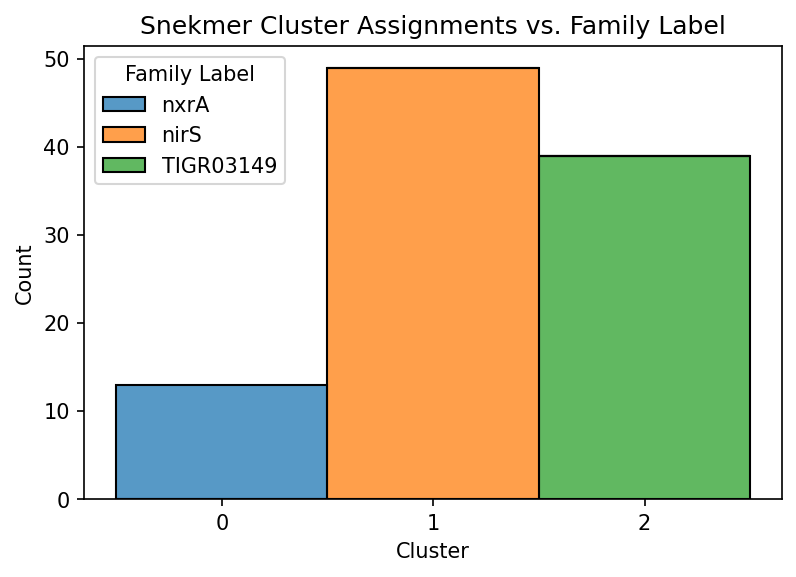

In [5]:
fig, ax = plt.subplots(dpi=150)
g = sns.histplot(x="cluster", hue="filename", multiple="stack", data=results, ax=ax)

ax.set_xlabel("Cluster")
ax.set_title("Snekmer Cluster Assignments vs. Family Label")
g.legend_.set_title("Family Label")

In this case, the true family labels are well-resolved by Snekmer's clustering algorithm. This result arises from the relative separation between sequences in each of these 3 families in terms of their amino acid recoding (AAR)-kmer profile. This will not always be the case for a given set of input sequences.

## Snekmer Model Mode

We also train a kmer-based scoring model for the family of interest based on the prevalence of kmers in each family. The scoring model is then used to develop in-family vs. out-of-family classification models. Snekmer scoring output files can be found in the **score** directory, and model output files can be found in the **model** directory.

### Kmer Probability Scores for Family Assignment

For simplicity, below we will highlight one particular family chosen at random and display the kmer probability scores for assignment into the example family. However, Snekmer generates individual scoring models for each family, so feel free to explore the other family probability scores in the same manner.

In [6]:
example_family = np.random.choice(families)
print("example family:\t", example_family)

# show relevant subset of columns
example_score_output = pd.read_csv(
    os.path.join("demo_example", "output", "scoring", "sequences", f"{example_family}.csv.gz")
)[["filename", "sequence_id", "label", f"{example_family}_score"]]
example_score_output

example family:	 TIGR03149


,filename,sequence_id,label,TIGR03149_score
0,nxrA,WP_013249767.1,nxrA,0.102714
1,nxrA,WP_080885705.1,nxrA,0.027030
2,nxrA,WP_013249749.1,nxrA,0.107812
3,nxrA,WP_053381689.1,nxrA,0.048270
4,nxrA,WP_080885591.1,nxrA,0.060155
...,...,...,...,...
96,nirS,WP_011383805.1,nirS,0.044706
97,nirS,WP_049724801.1,nirS,0.042535
98,nirS,WP_041099757.1,nirS,0.051193
99,nirS,WP_015258444.1,nirS,0.071264


In [7]:
# first 10 probability scores for in-family kmers
example_score_output[example_score_output["label"] == example_family].head(10)

,filename,sequence_id,label,TIGR03149_score
13,TIGR03149,WP_017422323.1,TIGR03149,0.625590
14,TIGR03149,YP_204935.1,TIGR03149,0.596738
15,TIGR03149,WP_005721361.1,TIGR03149,0.760056
16,TIGR03149,NP_798306.1,TIGR03149,0.465294
17,TIGR03149,NP_439225.1,TIGR03149,0.660117
18,TIGR03149,WP_045102325.1,TIGR03149,0.565506
19,TIGR03149,WP_017820467.1,TIGR03149,0.404533
20,TIGR03149,WP_010944374.1,TIGR03149,0.649658
21,TIGR03149,WP_014992036.1,TIGR03149,0.657690
22,TIGR03149,WP_011218001.1,TIGR03149,0.478748


In [8]:
# first 10 probability scores for out-of-family kmers
example_score_output[example_score_output["label"] != example_family].head(10)

,filename,sequence_id,label,TIGR03149_score
0,nxrA,WP_013249767.1,nxrA,0.102714
1,nxrA,WP_080885705.1,nxrA,0.027030
2,nxrA,WP_013249749.1,nxrA,0.107812
3,nxrA,WP_053381689.1,nxrA,0.048270
4,nxrA,WP_080885591.1,nxrA,0.060155
5,nxrA,WP_053381686.1,nxrA,0.016777
6,nxrA,WP_053378142.1,nxrA,0.016095
7,nxrA,WP_053381277.1,nxrA,0.009149
8,nxrA,WP_080886776.1,nxrA,0.096445
9,nxrA,WP_053381280.1,nxrA,0.018812


Column descriptions are as follows:

| **Column Name** | **Description**                                                                                                                |
|-----------------|--------------------------------------------------------------------------------------------------------------------------------|
| filename        | Name of file containing given sequence                                                                                         |
| sequence_id     | Sequence ID, as taken from FASTA file                                                                                          |
| label           | Label (i.e., family assignment) of the given sequence                                                                          |
| \<FAMILY>\_score  | Score for the assignment of the sequence into the given family. M inimum possible score is -1; maximum possible score is 1.0.  |

Perhaps unsurprisingly, the kmer probability scores for assignment into the example family differ significantly for sequences that are in-family vs. out-of-family.

To better illustrate this point, we can generate boxplots of the probability score distributions per family.

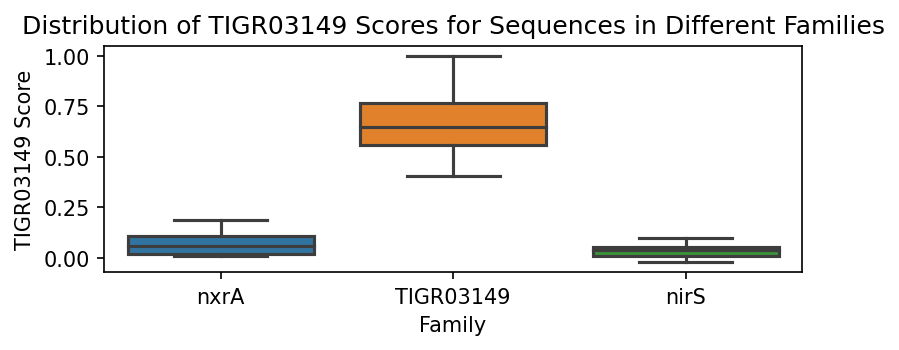

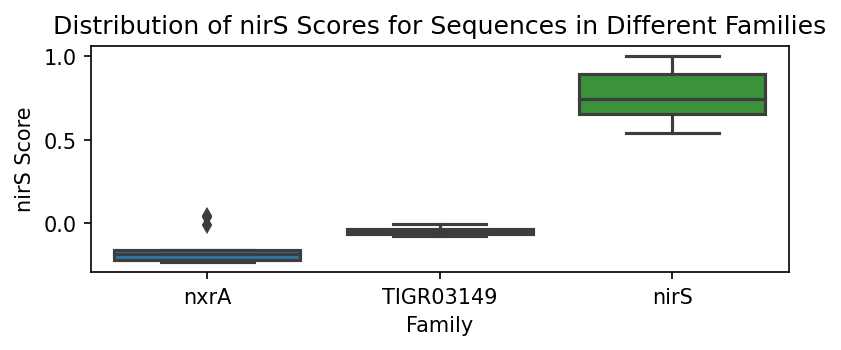

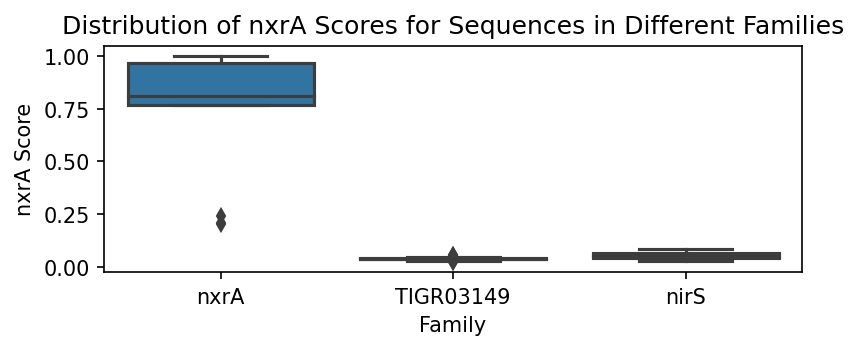

In [9]:
for fam in families:
    example_score_output = pd.read_csv(
        os.path.join("demo_example", "output", "scoring", "sequences", f"{fam}.csv.gz")
    )[["filename", "sequence_id", "label", f"{fam}_score"]]

    plt.figure(figsize=(6, 2), dpi=150)
    ax = sns.boxplot(x="label", y=f"{fam}_score", data=example_score_output)

    ax.set_title(f"Distribution of {fam} Scores for Sequences in Different Families")
    ax.set_xlabel("Family")
    ax.set_ylabel(f"{fam} Score")

We can assess how well the scores perform using the weights determined for each family. Note that it is immediately obvious that each of the family scoring methods performs well in identifying in-family sequences versus out-of-family sequences.

Not all family scoring methods perform equally well in terms of differentation between sequences belonging to different families. Differing scorer performances can be attributed to a variety of factors, e.g. parameters such as the alphabet and k, existing levels of similarity between sequences in different families, etc. The specificity of a given family kmer probability scorer is also impacted by (a) the selected family sequence set, and (b) the sequence set of the out-of-family kmers. In other words, as in other machine learning problems, the curation of the training set will strongly impact the resulting model.

The probabilities and scores assigned to each feature in the kmer set is also computed and output into a dataframe. The contents of one of these dataframes is as follows:

In [10]:
print("example family:\t", example_family)
pd.read_csv(os.path.join("demo_example", "output", "scoring", "weights", f"{example_family}.csv.gz"))

example family:	 TIGR03149


,kmer,sample,background
0,VSSSSSSSVVVVVV,0.179487,NaN
1,SSSSSSSVVVVVVV,0.179487,NaN
2,SSSSSSVVVVVVVV,0.179487,NaN
3,SSSSSVVVVVVVVV,0.051282,NaN
4,SSSSVVVVVVVVVS,0.015437,NaN
...,...,...,...
1672,VVVSSSVSVSSSSS,0.025641,NaN
1673,VVSVSVSSSSSSVV,0.025641,NaN
1674,SVSSSSSSVVSSVV,0.025641,NaN
1675,VSSSSSSVVSSVVS,-0.012821,NaN


In this view, the relative weight of a given AAR-kmer to a given family assignment is summarized. Each column displays the following information:

| **Column Name** | **Description**                                                                                                                |
|-----------------|--------------------------------------------------------------------------------------------------------------------------------|
| kmer            | Amino acid reduced (AAR) kmer                                                                                                  |
| sample          | Weight of the AAR-kmer toward family assignment based on prevalence in sample sequences                                        |
| background      | Weight of the AAR-kmer toward family assignment based on prevalence in sample sequences; `np.nan` if no background sequences are given |

Note that this example does not include any sequences specified as background sequences, and thus the `background` column does not contribute additional weights in scoring.

The model objects can be loaded (via `snekmer.io.load_pickle`) and then applied elsewhere, e.g. to a new set of unknown sequences.

## Snekmer Search Mode

Say a user trains the four models above, and would then like to score and evaluate sequences with unknown family assignments. The user can use `snekmer search`, which uses the kmer basis set for the desired family to create kmer vectors for unknown sequences, then apply the family scorer to the vectorized unknown sequences, and finally use the model to predict family assignments for the unknown sequences.

The results from `snekmer search` on the demo files are shown below:

In [11]:
print("example family:\t", example_family)
pd.read_csv(
    os.path.join("demo_example", "output", "search", example_family, f"{example_family}.csv")
)

example family:	 TIGR03149


,filename,sequence_id,sequence_length,score,in_family,probability,model
0,TIGR03149.faa,WP_017422323.1,228,0.618018,True,0.805785,TIGR03149.model
1,TIGR03149.faa,YP_204935.1,228,0.564928,True,0.762935,TIGR03149.model
2,TIGR03149.faa,WP_005721361.1,226,0.727920,True,0.875304,TIGR03149.model
3,TIGR03149.faa,NP_798306.1,228,0.467964,True,0.669274,TIGR03149.model
4,TIGR03149.faa,NP_439225.1,225,0.591324,True,0.785015,TIGR03149.model
5,TIGR03149.faa,WP_045102325.1,228,0.568916,True,0.766369,TIGR03149.model
6,TIGR03149.faa,WP_017820467.1,228,0.368263,True,0.556724,TIGR03149.model
7,TIGR03149.faa,WP_010944374.1,225,0.655749,True,0.832490,TIGR03149.model
8,TIGR03149.faa,WP_014992036.1,225,0.639143,True,0.821116,TIGR03149.model
9,TIGR03149.faa,WP_011218001.1,230,0.370323,True,0.559154,TIGR03149.model


Each column summarizes the following information for a given sequence:

| **Column Name** | **Description**                                                                                                                |
|-----------------|--------------------------------------------------------------------------------------------------------------------------------|
| filename        | Name of file containing given sequence                                                                                         |
| sequence_id     | Sequence ID, as taken from FASTA file                                                                                          |
| sequence_length | Length of sequence (i.e. number of characters long the sequence is)                                                            |
| score           | Score for the assignment of the sequence into the desired family based on the family model. Scores are summed from kmer contributions using the family scoring model |
| in_family       | True if in-family assignment is predicted (probability > 0.5); False otherwise.                                                |
| probability     | Probability of in-family assignment. 1.0 = maximum probability for a given sequence's assignment into a family; 0.0 = lowest probability; 0.5 = equal probability of in-family vs. out-of-family assignment                                                                     |
| model           | Name of model used to evaluate the sequence                                                                                     |

In this example application, the **in_family** and **probability** columns are of particular importance to the user. The **in_family** column tells the user whether a particular input sequence is given an in-family assignment based on the machine learning model which has been previously trained, and the **probability** informs the user of the in-family assignment probability determined by the same model.

In the case of the demo files, since all of the sequences above belong to the given family, and by design of the demo were also the families used to train the family model, the sequences all have relatively high probabilities and consistently do get assigned to the protein family. However, in this demonstration, we hope it is apparent to the user how trained protein family models can be applied to a new sequence set and the resulting `snekmer search` results evaluated.

## Conclusion

In conclusion, we have demonstrated Snekmer's utility across 3 potential operating models (cluster, model, and search). We hope this tutorial provides useful information to users regarding applying Snekmer to their own sequence sets and interpreting results from Snekmer.